In [1]:
import numpy as np
import pandas as pd
import os.path as osp
import torch
from tqdm import tqdm
from joblib.parallel import Parallel, delayed
from matplotlib import pyplot as plt
from copy import deepcopy

from molecules.parse_sdf import get_num_atoms_from_smiles


In [2]:
SEED = 42
ROOT = "."
DATASET = osp.join(ROOT, "pcqm4m-v2-geometry-normed.csv.gz")
VAL_RATIO = 0.1
TEST_RATIO = 0.1
MAX_ATOMS_IN_TRAIN = 15
NUMATOMS_500k_DIR = osp.join(ROOT, "pcqm500k_num_atoms_split_dict.pt")

In [3]:
smiles = pd.read_csv(DATASET, nrows=None, usecols=["smiles"])["smiles"]
smiles

0          O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C
1                  COc1cc(OC)ccc1/C=C/N(C(=O)C)C
2                    C=CCN(C(=O)C)/C=C/c1ccccc1C
3                    C=CCN(C(=O)C)/C=C/c1ccccc1F
4                   C=CCN(C(=O)C)/C=C/c1ccccc1Cl
                           ...                  
3378521    Cc1ccc(c(c1)C)N[C@H](/C(=N\C1CC1)/O)C
3378522     C[C@@H](/C(=N\C1CC1)/O)Nc1cccc(c1C)C
3378523     C[C@H](/C(=N\C(=N)O)/O)Nc1cccc(c1C)C
3378524    C[C@@H](/C(=N\C(=N)O)/O)Nc1cccc(c1C)C
3378525              CCOc1ccccc1NC/C(=N\C1CC1)/O
Name: smiles, Length: 3378526, dtype: object

In [4]:
num_atoms = Parallel(n_jobs=-1)(delayed(get_num_atoms_from_smiles)(s) for s in tqdm(smiles))

100%|██████████| 3378526/3378526 [06:08<00:00, 9156.81it/s] 


In [5]:
def create_numatoms_split_500k(num_atoms_list, val_ratio, test_ratio, max_atoms_in_train):
    """ Create split by the size of molecules, testing on the largest ones.
    Args:
        num_atoms_list: List with molecule size per each graph.
    """
    N = int(5e5)
    N_train = int(N * (1 - val_ratio - test_ratio))
    N_val = int(N * val_ratio)
    N_test = N - N_train - N_val
    rng = np.random.default_rng(seed=SEED)
    train_ratio = 1 - val_ratio - test_ratio

    num_atoms_uniq, num_atoms_inv, num_atoms_count = np.unique(
                num_atoms_list, return_inverse=True, return_counts=True)
    weights = num_atoms_count.astype(float)[num_atoms_inv] ** -1
    weights_train = deepcopy(weights)
    weights_train[(num_atoms_uniq >= max_atoms_in_train)[num_atoms_inv]] = 0
    weights_train /= np.sum(weights_train)

    weights_valtest = deepcopy(weights)
    weights_valtest[(num_atoms_uniq < max_atoms_in_train)[num_atoms_inv]] = 0
    weights_valtest /= np.sum(weights_valtest)


    # Split based on mol size into 90/5/5, but shuffle the top 10% randomly
    # before splitting to validation and test set.

    train_ind = rng.choice(np.arange(len(num_atoms_list)), size=N_train, replace=False, p=weights_train)
    val_test_ind = rng.choice(np.arange(len(num_atoms_list)), size=N_val+N_test, replace=False, p=weights_valtest)
    val_ind = val_test_ind[:N_val]
    test_ind = val_test_ind[N_val:]
    assert len(train_ind) + len(val_ind) + len(test_ind) == N
    assert check_splits(N, [train_ind, val_ind, test_ind], [train_ratio, val_ratio, test_ratio])

    size_split = {'train': train_ind, 'val': val_ind, 'test': test_ind}
    torch.save(size_split, osp.join(ROOT, NUMATOMS_500k_DIR))

def check_splits(N, splits, ratios):
    """ Check whether splits intersect and raise error if so.
    """
    assert sum([len(split) for split in splits]) == N
    for ii, split in enumerate(splits):
        true_ratio = len(split) / N
        assert abs(true_ratio - ratios[ii]) < 3/N
    for i in range(len(splits) - 1):
        for j in range(i + 1, len(splits)):
            n_intersect = len(set(splits[i]) & set(splits[j]))
            if n_intersect != 0:
                raise ValueError(
                    f"Splits must not have intersecting indices: "
                    f"split #{i} (n = {len(splits[i])}) and "
                    f"split #{j} (n = {len(splits[j])}) have "
                    f"{n_intersect} intersecting indices"
                )
    return True

In [6]:
create_numatoms_split_500k(num_atoms, VAL_RATIO, TEST_RATIO, MAX_ATOMS_IN_TRAIN)

In [7]:
num_atoms_split = torch.load(NUMATOMS_500k_DIR)

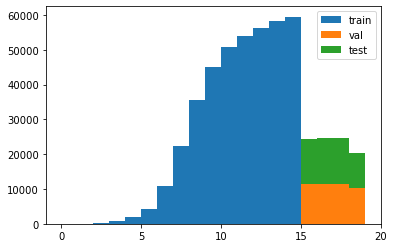

In [8]:
plt.figure()
max_len = max([len(idx) for idx in num_atoms_split.values()])
arr = []
for idx in num_atoms_split.values():
    this_arr = np.nan + np.zeros(max_len)
    this_arr[:len(idx)] = np.array(num_atoms)[idx]
    arr.append(this_arr)
arr = np.stack(arr, axis=1)

plt.hist(arr, stacked=True, bins=np.arange(0, np.nanmax(arr)), log=False)
plt.xticks(np.arange(0, 25, 5))
plt.legend(num_atoms_split.keys())